# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to turn our chatbot into a simple [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/).

The chatbot previously *always* reflected on the conversation and saved memories. 

The central difference is that the agent will decide *when* to save memories. 

For this, we're going to introduce a simple [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) to help manage a ToDo list. 

This agent will manage semantic memory, general profile of the user as well as a collection of ToDos.

It will also manage procedural memory, allow the user to update their preferences for creating ToDo items. 

In [19]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Looking under the hood

We can see specific changes planned and made by Trustcall.

In [13]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [15]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls for the call
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add visibility into the tool calls made by Trustcall
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [17]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_kYrhaQXtxDhtkmbmSbUVoyHs)
 Call ID: call_kYrhaQXtxDhtkmbmSbUVoyHs
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [18]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [19]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_kYrhaQXtxDhtkmbmSbUVoyHs'}


In [20]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [21]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [26]:
print("Patches generated")
spy.called_tools

Patches generated


[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add the new memory about going to Tartine and eating a croissant after the bike ride. Then, add the memory about thinking about Japan and planning to go back this winter.',
    'patches': [{'op': 'add',
      'path': '/content',
      'value': ' After the ride, Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and planning to go back this winter.'}]},
   'id': 'call_4z1KiggmnGFRd4X9DrL14HLY',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'After the ride, Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and planning to go back this winter.'},
   'id': 'call_Qzkg3mi9bxovzmej8EuPQM0C',
   'type': 'tool_call'}]]

In [33]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Use it with your result
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: Add the new memory about going to Tartine and eating a croissant after the bike ride. Then, add the memory about thinking about Japan and planning to go back this winter.
Added content:  After the ride, Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and planning to go back this winter.

New Memory created:
Content: {'content': 'After the ride, Lance went to Tartine and ate a croissant. He was also thinking about his trip to Japan and planning to go back this winter.'}


## Creating an agent

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [2]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [3]:
_set_env("OPENAI_API_KEY")

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

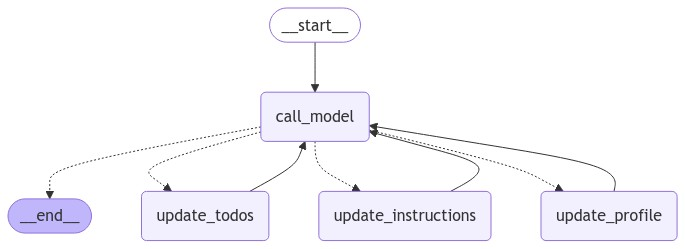

In [40]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_memory")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_4ebGbDNIDM3zsMXcJOoKS956)
 Call ID: call_4ebGbDNIDM3zsMXcJOoKS956
  Args:
    update_type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it! How can I assist you today, Lance?


In [42]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_mGAAgxmO6KmDnf52GeZNeTD4)
 Call ID: call_mGAAgxmO6KmDnf52GeZNeTD4
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'solutions': ['Check local swim schools in SF like La Petite Baleen or Pomeroy Recreation & Rehabilitation Center.', 'Look for baby swim classes at the YMCA or community centers.', 'Consider private swim instructors who specialize in infant swim lessons.']}
================================== Ai Message ==================================

I've added "Book swim lessons for the baby" to your ToDo list. If you need any help with that, feel free to ask!


In [43]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_2a3KQLUNavxBOQcSEeUcb8ca)
 Call ID: call_2a3KQLUNavxBOQcSEeUcb8ca
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

I've updated the instructions to include specific local businesses or vendors when creating or updating ToDo items. If there's anything else you'd like to adjust, just let me know!


In [44]:
# Check for updated instructions
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    print(memory.value)

{'memory': "Based on your feedback, here are the updated instructions for creating or updating ToDo list items:\n\n<current_instructions>\nWhen creating or updating ToDo items, include specific local businesses or vendors relevant to the task. For example, if the task is to book swim lessons, suggest local swim schools or instructors in the user's area.\n</current_instructions>\n\nIf there's anything else you'd like to adjust, just let me know!"}


In [45]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_lPqNahInvJ53GLUq2v2MUK0i)
 Call ID: call_lPqNahInvJ53GLUq2v2MUK0i
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'solutions': ['Contact a local locksmith specializing in electronic locks.', 'Check troubleshooting guides on the Yale website.', "Consider replacing the lock if it's under warranty."]}

Document 23950598-cc26-4f47-a918-1a5d1ec4025d updated:
Plan: Add specific local businesses or vendors to the solutions list for the task 'Book swim lessons for the baby'.
Added content: Contact La Petite Baleen or Pomeroy Recreation & Rehabilitation Center for availabilit

In [46]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': None, 'solutions': ['Check local swim schools in SF like La Petite Baleen or Pomeroy Recreation & Rehabilitation Center.', 'Look for baby swim classes at the YMCA or community centers.', 'Consider private swim instructors who specialize in infant swim lessons.', 'Contact La Petite Baleen or Pomeroy Recreation & Rehabilitation Center for availability and pricing.']}
{'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Contact a local locksmith specializing in electronic locks.', 'Check troubleshooting guides on the Yale website.', "Consider replacing the lock if it's under warranty."]}


In [47]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_QKzNerk6Z74fiLC6CMzdOgio)
 Call ID: call_QKzNerk6Z74fiLC6CMzdOgio
  Args:
    update_type: todo
================================= Tool Message =================================

Document 23950598-cc26-4f47-a918-1a5d1ec4025d updated:
Plan: Add a deadline to the task 'Book swim lessons for the baby'.
Added content: 2024-11-30T23:59:59
================================== Ai Message ==================================

I've updated the deadline for booking swim lessons for the baby to the end of November. If there's anything else you need, feel free to ask!


Trace to see task updating:

https://smith.langchain.com/public/b44a037d-e4a0-445c-98d2-6b67380117df/r

Specifically, we can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/b44a037d-e4a0-445c-98d2-6b67380117df/r

In [48]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_z6yFE3tYhM7aMXZXlvIsgLqb)
 Call ID: call_z6yFE3tYhM7aMXZXlvIsgLqb
  Args:
    update_type: todo
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back City Toyota to schedule car service.', 'time_to_complete': 15, 'solutions': ["Check the car's service history to know what needs to be done.", 'Prepare any questions about the service or costs.', 'Find a convenient time slot for the service appointment.']}

Document 1067940f-4f84-4a72-b651-eb93120e8661 updated:
Plan: Add specific local businesses or vendors to the solutions list for the task 'Fix the jammed electric Yale lock on the door'.
Added content: Contact San Francisco Lock and Key for assistance.
==============

In [49]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'task': 'Book swim lessons for the baby.', 'time_to_complete': 30, 'deadline': '2024-11-30T23:59:59', 'solutions': ['Check local swim schools in SF like La Petite Baleen or Pomeroy Recreation & Rehabilitation Center.', 'Look for baby swim classes at the YMCA or community centers.', 'Consider private swim instructors who specialize in infant swim lessons.', 'Contact La Petite Baleen or Pomeroy Recreation & Rehabilitation Center for availability and pricing.']}
{'task': 'Fix the jammed electric Yale lock on the door.', 'time_to_complete': 60, 'deadline': None, 'solutions': ['Contact a local locksmith specializing in electronic locks.', 'Check troubleshooting guides on the Yale website.', "Consider replacing the lock if it's under warranty.", 'Contact San Francisco Lock and Key for assistance.']}
{'task': 'Call back City Toyota to schedule car service.', 'time_to_complete': 15, 'deadline': None, 'solutions': ["Check the car's service history to know what needs to be done.", 'Prepare any 

Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [50]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

You can complete the following tasks in 30 minutes or less:

1. **Book swim lessons for the baby** - Estimated time: 30 minutes
2. **Call back City Toyota to schedule car service** - Estimated time: 15 minutes

Would you like to work on one of these tasks now?


In [51]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are some options for booking swim lessons for your baby in SF:

1. **La Petite Baleen** - They offer swim classes for infants and might have availability. You can contact them to check their schedule and pricing.

2. **Pomeroy Recreation & Rehabilitation Center** - Another local option that provides swim lessons. Reach out to them for more details on their infant swim classes.

3. **YMCA or Community Centers** - Check if your local YMCA or community centers offer baby swim classes.

4. **Private Swim Instructors** - Consider looking for private instructors who specialize in infant swim lessons.

Would you like more information on any of these options?


Trace: 

https://smith.langchain.com/public/e0b4c80b-5d91-4085-bc8e-da3057c3fd29/r

## Studio

### Creating ToDOs

* Tool use to create specific long-term memories (ToDos, user-profile, instructions)

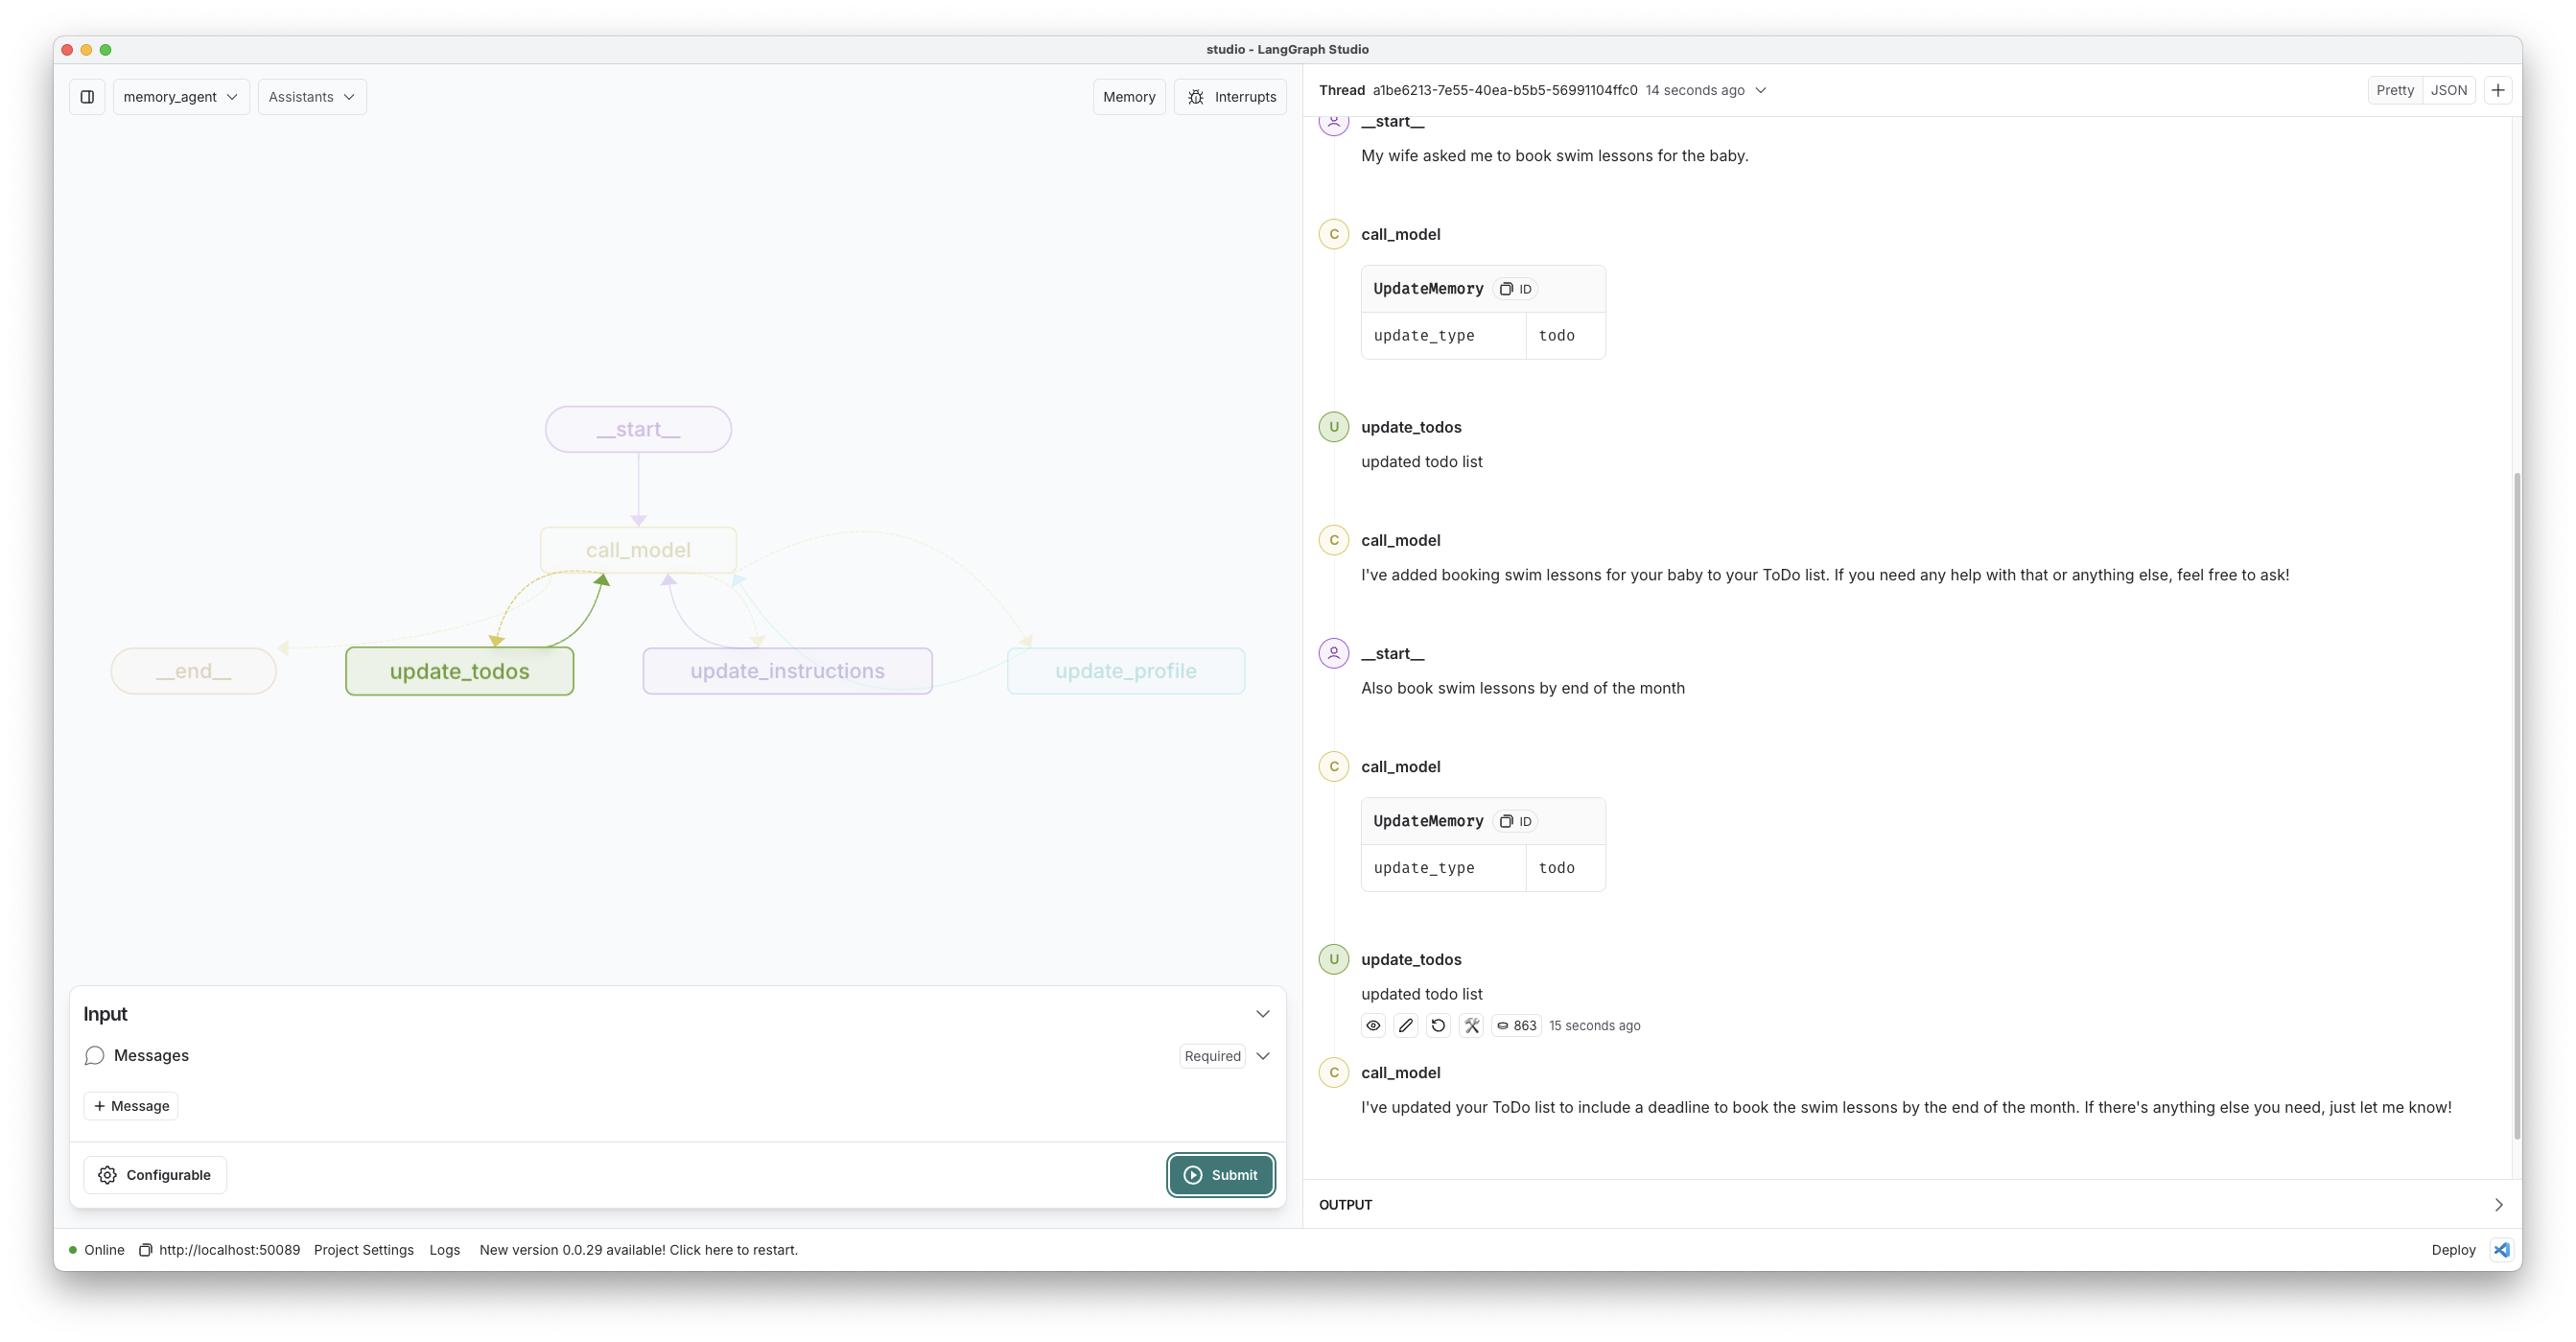

### Tackling ToDOs

* Asking the assistant for help

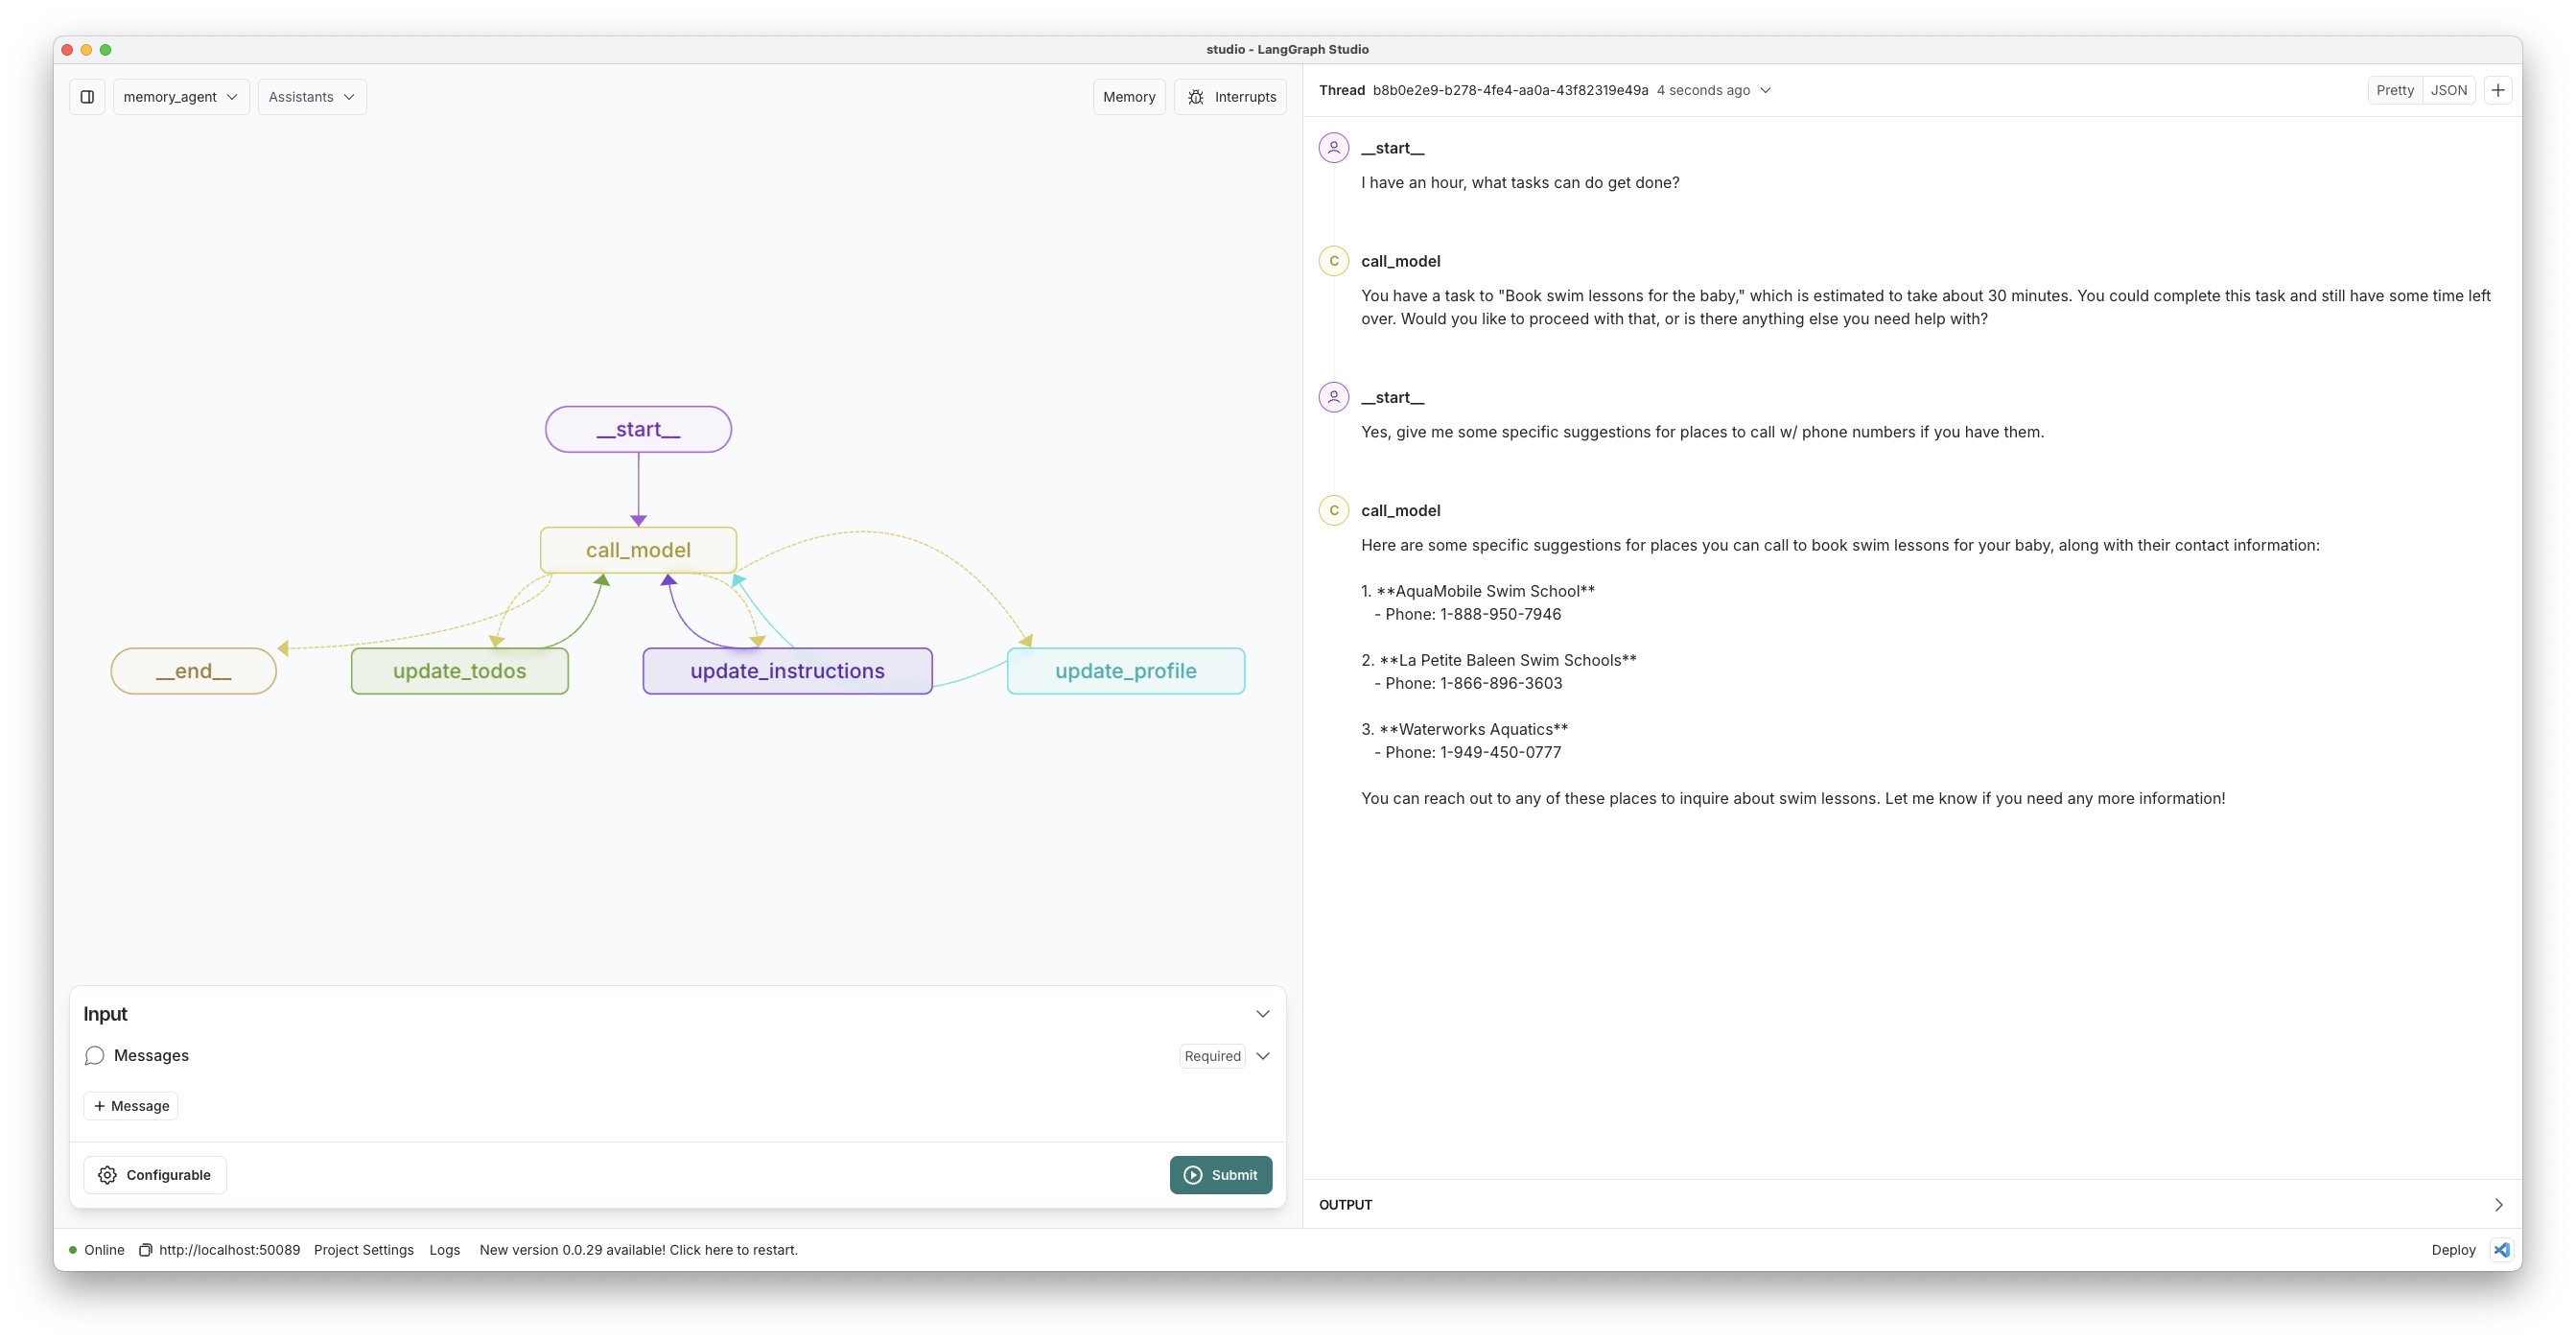